

<p style="width:35%;float:right;padding-left:50px">
<img src=http://www.illusionsprojektor.de/wp-content/uploads/2014/11/interstellar-3840x2160-300x190.jpg>
<span style="font-size:smaller">
</span>
</p>
</span>
</p>

# *Finite Difference - Summation By Part (SBP)*

### Kenneth Duru

In [1]:
# This is a configuration step for the exercise. Please run it before the simulation code!
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from Dx import Dx
from Dy import Dy
from Dq import Dq
from Dr import Dr
from Dxx import D_xx
from Dyy import D_yy
from Dqq_mu import Dqq_mu
from Drr_mu import Drr_mu
from Gen_Surf_Mesh import Gen_Surf_Mesh
from Traction_2d import Traction_2d
from copy import deepcopy

# Show the plots in the Notebook.
plt.switch_backend("nbagg")

<IPython.core.display.Javascript object>


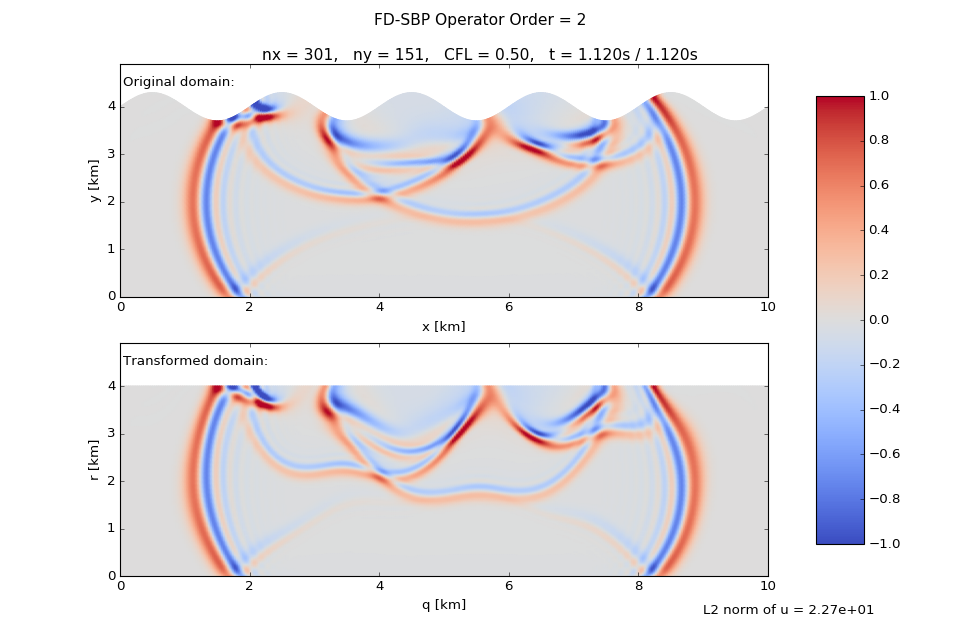

In [30]:
# Inhomeneous 2D wave equation with curvilinear coordinates q,r
#
# rho u_tt =  (mu u_x)_x +  (mu u_y)_y    on  x,y in domain
# density: rho, shear modulus: mu
#
# -> J rho u_tt =  (\hat{G} u_q)_q + (\hat{G} u_r)_r
#
# where J is the Jacobian
#
# Boundary Conditions:
#  x= +-Lx: Z_s*u_t +- mu*u_x = 0
#  y= Ly: Z_s*u_t + mu*u_y = 0
#  free-surface topography: =  mu*u_y = 0
 
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                                     Parameters 
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
order = 2     # spatial order of accuraccy: 2, 4, 6
mx = 301      # number of grid points in x direction
my = 151       # number of grid points in y direction

xMin = 0      # physical dimension of domain 
xMax = 10    
yMin = 0
yMax = 4
hx = (xMax-xMin)/(mx-1)
hy = (yMax-yMin)/(my-1)

topo = 0.3    # amplitude of sinuisoidal surface

# Time-stepping parameters
nt = 800      # number of time steps
tmax = 20.0
cmax = 3.464
cfl = 0.5
isnap = 10    # snapshot frequency

isx = mx / 2  # source index x
isz = my / 2  # source index z
ist = 100     # shifting of source time function
f0 = 100.0    # dominant frequency of source (Hz)
T = 1.0 / f0  # dominant period


# Receiver locations
irx = np.array([int(np.floor(0.2*mx)), int(np.floor(0.4*mx)), int(np.floor(0.6*mx)), int(np.floor(0.8*mx))])
irz = np.array([int(np.floor(0.1*my)), int(np.floor(0.1*my)), int(np.floor(0.1*my)),int(np.floor(0.1*my))])
seis = np.zeros((len(irx), nt+1))


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                                     TGenerate Mesh & Topography
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# initialize the bounds of our rectangular block
XB = np.linspace(xMin, xMax, mx)
XT = np.linspace(xMin, xMax, mx)
YL = np.linspace(yMin, yMax, my)
YR = np.linspace(yMin, yMax, my)
 
XL = np.ones(my)
XR = np.ones(my)
YB = np.ones(mx)
YT = np.ones(mx)
 
XL = XB[0]*XL
XR = XB[mx-1]*XR

# perturb the topography with a np.sin funtion
YB = YL[0]*YB #+ 0.0*topo * np.sin(2*np.pi*XB)
YT = YL[my-1]*YT + topo * np.sin(np.pi*XT) 
                                    
 
# code for creation of mesh (X,Y)
X, Y = Gen_Surf_Mesh(mx,my,XL,XR,XB,XT,YL,YR,YB,YT)
 
# boundary conditions
bcTypeR = 'traction'
bcTypeQ = 'traction'
option = {
    'bcTypeR' : bcTypeR,
    'bcTypeQ' : bcTypeQ
}
 

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                                     Coordinate Transform  
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# dicretize the tranformed domain: the unite square (q,r) = [0,1]**2
hq = 1.0/(mx-1)
hr = 1.0/(my-1)
q = np.linspace(0, 1, mx)
r = np.linspace(0, 1, my)
 
# print(q[mx-1], r[my-1])
 
Q, R = np.meshgrid(q, r)
 
# compute metric derivatives and Jacobian
y_r = Dr(Y,hr,order,option)
y_q = Dq(Y,hq,order,option)
x_r = Dr(X,hr,order,option)
x_q = Dq(X,hq,order,option)
 
J = np.multiply(x_q, y_r) - np.multiply(y_q, x_r)  # Jacobian (determinant of metric)
 
q_x =   np.divide(y_r, J)
r_x = - np.divide(y_q, J)
q_y = - np.divide(x_r, J)
r_y =   np.divide(x_q, J)

dt = cfl/cmax*min(hq,hr)/max(np.max(np.sqrt((np.square(q_x) + np.square(q_y)))), np.max(np.sqrt((np.square(r_x) + np.square(r_y))))) 
t, _ = np.linspace(0, tmax, retstep=dt)
 
 
# material properties (can be heterogenous)
rho = 2.5001 + 0.0*X
#rho(:, ceil(mx/2)-15:ceil(mx/2)+15) = 2.5001
G = rho*cmax**2 + 0.0*X
 
# SBP penalty weights
if (order==2):
    hq11 = 0.5*hq
    hr11 = 0.5*hr
 
elif (order == 4):
    hq11 = (17/48)*hq
    hr11 = (17/48)*hr
 
elif(order == 6):
    hq11 = 13649/43200*hq
    hr11 = 13649/43200*hr
 
# penalty coefficients
penq = np.sqrt(np.square(q_x) + np.square(q_y))/hq11
penr = np.sqrt(np.square(r_x) + np.square(r_y))/hr11
 
# 2nd spatial deriv
A  = np.multiply(np.multiply(J,(np.square(q_x) + np.square(q_y))), G)
B  = np.multiply(np.multiply(J,(np.square(r_x) + np.square(r_y))), G)
C  = np.multiply(np.multiply(J,(np.multiply(r_x,q_x) + np.multiply(r_y,q_y))), G)
CT = np.multiply(np.multiply(J,(np.multiply(r_x,q_x) + np.multiply(r_y,q_y))), G) 
 
#  wave speed
cs = np.sqrt(np.divide(G,rho))
 
# initial src
amp = 20.0
cx = 0.5*(xMin + xMax)
cy = 0.5*(yMin + yMax) # location of center of Gaussian
delta = 0.01
 
u0 = amp* np.multiply(np.exp(-np.square((X-cx))/delta), np.exp(-np.square((Y-cy))/delta))
u = deepcopy(u0)
u0_t = 0* np.multiply(np.exp(-np.square((X-cx))/delta),np.exp(-np.square((Y-cy))/delta))
 
 
 
# compute the spatial approximations in the transformed domain using SBP
# operators
 
def Du(u, A, B, C, CT, G, hq, hr, order, option):
    return np.divide((Dqq_mu(u,A,hq,order,option) \
                    + Drr_mu(u,B,hr,order,option)\
                    + Dr(np.multiply(C ,Dq(u,hq,order,option)),hr,order,option)\
                    + Dq(np.multiply(CT,Dr(u,hr,order,option)),hq,order,option)), J)
 
Dmu = Du(u, A, B, C, CT, G, hq, hr, order, option) # without SAT
 
# compute the tranctions on the boundaries
Tq, Tr = Traction_2d(u,G,q_x,q_y,r_x,r_y, order,hq, hr,option)
 
# penalize the tranctions on the boundaries                    
Dmu[:,0] = Dmu[:,0] + np.multiply(penq[:,0],Tq[:,0])
Dmu[:,mx-1] = Dmu[:,mx-1] - np.multiply(penq[:,mx-1],Tq[:,mx-1])
Dmu[0,:] = Dmu[0,:] + np.multiply(penr[0,:],Tr[0,:])
Dmu[my-1,:] = Dmu[my-1,:] - np.multiply(penr[my-1,:],Tr[my-1,:])
 
 
# initial time-step compute the solutions
nn = 0
uNew = u + dt*u0_t + np.multiply(0.5*np.divide(dt**2,rho),Dmu)
 
# update the solutions
uPrev = deepcopy(u)
u = deepcopy(uNew)
 


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                                     Init Plot
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fig, ax = plt.subplots(nrows=2, figsize=(12, 8))

# Upper plot: original domain
plot_topo_domain = ax[0].pcolormesh(X, Y, u, vmin=-1, vmax=1, shading="gouraud", cmap="coolwarm")
ax[0].set_xlabel('x [km]')
ax[0].set_ylabel('y [km]')
ax[0].set_xlim([xMin,xMax])
ax[0].set_ylim([yMin,YT.max()+2*topo])
ax[0].annotate('Original domain:', xy=(0.005, 0.95), xycoords='axes fraction', fontsize=12, horizontalalignment='left', verticalalignment='top')

# Bottom plot: transformed domain
plot_transformed = ax[1].pcolormesh(xMax*Q, yMax*R, u, vmin=-1, vmax=1, shading="gouraud", cmap="coolwarm")
ax[1].set_xlabel('q [km]')
ax[1].set_ylabel('r [km]')
ax[1].set_xlim([0,xMax])
ax[1].set_ylim([0,YT.max()+2*topo])
ax[1].annotate('Transformed domain:', xy=(0.005, 0.95), xycoords='axes fraction', fontsize=12, horizontalalignment='left', verticalalignment='top')

# plot L2 norm of u at the bottom right corner
u_text = ax[1].text(0.9*xMax, -0.8, "L2 norm of u = ", fontsize=12)

# plot color bar at right margin 
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(plot_transformed, cax=cbar_ax)

# plot receivers
for x, z in zip(irx, irz):
    plt.text(x, z, 'x')

plt.text(isx, isz, 'o')

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                                     Time step  
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ir = np.arange(len(irx)-1)

plt.ion()          
plt.show()
  
# loop until the final time
for tInd in range(nt) :
    #np.linspace(2, np.ceil(len(t)/20-1)):
    nn += 1
    Dmu = Du(u, A, B, C, CT, G, hq, hr, order, option) # without SATo
 
    # compute the tranctions on the boundaries
    Tq, Tr = Traction_2d(u,G,q_x,q_y,r_x,r_y, order,hq, hr,option)
 
    # penalize the tranctions on the boundaries                    
    Dmu[:,0] = Dmu[:,0] + np.multiply(penq[:,0],Tq[:,0])
    Dmu[:,mx-1] = Dmu[:,mx-1] - np.multiply(penq[:,mx-1],Tq[:,mx-1])
    Dmu[0,:] = Dmu[0,:] + np.multiply(penr[0,:],Tr[0,:])
    Dmu[my-1,:] = Dmu[my-1,:] - np.multiply(penr[my-1,:],Tr[my-1,:])
 
    # interior
    uNew[:,:] = np.divide(Dmu[:,:]*dt**2,rho[:,:]) + 2.0*u[:,:] - uPrev[:,:]
 
    #uNew[0,:] = 0.0
    #uNew[my-1,:] = 0.0
    #uNew[:,0] = 0.0
    #uNew[:,mx-1] = 0.0
  
    # Boundaries
    #  the left  and right boundaries
    uNew[:,0] = (dt**2)*np.divide(Dmu[:,0],rho[:,0]) + 2.0*u[:,0] \
                + np.multiply((0.5*dt*np.multiply(cs[:,0],penq[:,0])-1),uPrev[:,0])
    uNew[:,0] = np.divide(uNew[:,0],(1.0+0.5*dt*np.multiply(cs[:,0],penq[:,0])))
 
    uNew[:,-1] = (dt**2)*np.divide(Dmu[:,-1],rho[:,-1]) + 2.0*u[:,-1] \
                   + np.multiply((-1.0 + 0.5*dt*np.multiply(cs[:,-1],penq[:,-1])),uPrev[:,-1])
    uNew[:,-1] =  np.divide(uNew[:,-1],(1.0+0.5*dt*np.multiply(cs[:,-1],penq[:,-1])))
 
  
    # bottom boundary
    #if "traction" in bcTypeR.lower():
    uNew[0,:] = dt**2*np.divide(Dmu[0,:],rho[0,:]) + 2.0*u[0,:] \
                + np.multiply((0.5*dt*np.multiply(cs[0,:],penr[0,:])-1.0),uPrev[0,:])
    uNew[0,:] = np.divide(uNew[0,:],(1.0+0.5*dt*np.multiply(cs[0,:],penr[0,:])))
    #uNew[-1,:] = dt**2*Dmu[-1,:],rho[-1,:]  + 2*u[-1,:] + np.multiply((cs[-1,:],0.5*dt,penr[-1,:]-1),uPrev[-1,:])
    #uNew[-1,:] = uNew[-1,:], np.multiply((1+cs[-1,:],0.5*dt,penr[-1, :])
   

    if nn % isnap == 0:                    # you can change the speed of the plot by increasing the plotting interval
        fig.suptitle("FD-SBP Operator Order = {:d}\n\nnx = {:d},   ny = {:d},   CFL = {:.2f},   t = {:.3f}s / {:.3f}s".format(order, mx, my, cfl, dt*(nn+1), dt*(nt+1)), fontsize=14)
        u_text.set_text('L2 norm of u = {:.2e}'.format(np.linalg.norm(uNew, 2)))
        
        plot_transformed.set_array(uNew.ravel())
        plot_topo_domain.set_array(uNew.ravel())
        #plt.draw()
        ax[0].figure.canvas.draw()
   
    #uPrev[:,:] = u[:,:]
    #u[:,:] = uNew[:,:]
    uPrev = deepcopy(u)
    u = deepcopy(uNew)
 
    # Save seismograms
    seis[ir, nn] = u[irz[ir], irx[ir]]
    
plt.ioff()
plt.show()


In [ ]:
import RK4

# ---------------------------------------------------------                                                                                            
# Simple finite difference solver
#
# elastic wave equation  rho*v_t = sigma_x +  src
#                        1/mu*sigma_t = v_x
# 1-D regular grid                         
                                                                                                              
# ---------------------------------------------------------
L = 10.0      # length of the domain [km]
tend = 8.0       # final time
nx = 500      # grid points in x                                                                                                                       
dx = L/nx     # grid increment in x
dt = 0.5*dx    # Time step
c0 = 3.464      # velocity (km/s) (can be an array)                                                                                                             
isx = nx / 2  # source index x                                                                                                                          
ist = 100     # shifting of source time function                                                                                                       
f0 = 100.0    # dominant frequency of source (Hz)
isnap = 5    # snapshot frequency
T = 1.0 / f0  # dominant period
order = 4          # order of accuracy

rho = 2.6702       # density [g/cm^3]
mu = rho*c0**2     # shear modulus [GPa]

dt = 0.5/c0*dx     # Time step
nt = int(round(tend/dt))      # number of time steps


# reflection coefficients: -1<= r <= 1
# (clamped: r = -1; free-surface: r = 1, non-reflecting: r = 0)
r0 = 1.0          # left boundary
r1 = -1.0         # right boundary

# Initialize: particle velocity (v); and shear stress (s)
v = np.zeros((nx, 1))
s = np.zeros((nx, 1))

#Initialize the domain
x = np.zeros((nx, 1))

# Initial particle velocity perturbation and discretize the domain
sigma = 0.3
for j in range(0, nx):
    v[j, :] = np.exp(-np.log(2)*((j-isx)*dx)**2/(2*sigma**2))  # particle velocity
    x[j, :] = j*dx                                     # discrete domain

# Inialize the plot
plt.show()
plt.ion()
fig = plt.figure()
image, = plt.plot(x, v)#, animated=True)
plt.ylabel('v [m/s]')
plt.xlabel('x [km]')
plt.gca().set_ylim([-0.5*v.max(), v.max()])

# Evolve the solution for nt time-steps using 4th order Runge-Kutta method
for it in range(nt):
    
    RK4.elastic_RK4(v, s, v, s, rho, mu, nx, dx, order, dt, r0, r1)
    
    t = (it+1)*dt
    # print('time = ', t)
    if it % isnap == 0: 
       
        plt.title("time = %.2f s" % t)
        #plt.plot(x, v)
        image.set_ydata(v)
        #plt.gcf().canvas.draw()
        #plt.colorbar()
        fig.canvas.draw()


#plt.ioff()
plt.show()

